In [1]:
import pandas as pd
import numpy as np
import csv
import os
from os import path
import weblogo
import seqlogo
%matplotlib inline

In [2]:
filteredGeneList = pd.read_csv('../Database/filteredGenesDetails_human_240118.txt',sep='\t')
acc2gene={}
gene2acc={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']
    gene2acc[row['GeneName']] = row['AccNum']

In [3]:
def get_fa(filename,onlyKeys = 'All'):
    keyD = dict()
    if onlyKeys!='All':
        for k in onlyKeys: keyD[k] = None
        
    def addEntry(current,d):
        entry = current.split('\n')
        if entry[0]!='' and (onlyKeys=='All' or keyD.has_key(entry[0])):
            d[entry[0]] = ''.join(entry[1:])

    d = dict()
    bf = open(filename)
    current = ['\n']
    for line in bf:
        if line[0]=='>':
            addEntry(''.join(current),d)
            if len(line)>1: current = [line[1:]]
            else: current = ['\n']
        else: current.append(line)
    addEntry(''.join(current),d)
    bf.close()
    return d

In [4]:
splicedGenes = get_fa('../Database/splicedGenes_240118.txt')
## truncate the keys to only accNum
ks = list(splicedGenes.keys())
for key in ks:
    splicedGenes[key.split('_chr')[0]] = splicedGenes[key]
    splicedGenes.pop(key)
splicedORFs = get_fa('../Database/splicedORFs_240118.txt')

In [5]:
fpUTR={}
tpUTR = {}
ORFs = {}
for idx,row in filteredGeneList.iterrows():
    accNum = row['AccNum']
    fpLen = row['fpUTR_length']
    tpLen = row['tpUTR_length']
    fpUTR[accNum] = splicedGenes[accNum][0:fpLen]
    tpUTR[accNum] = splicedGenes[accNum][-tpLen:]
    ORFs[accNum] = splicedORFs[accNum]

In [6]:
!dir
def write_fa(dic,fname):
    with open(fname, 'a') as the_file:
        for key in dic.keys():
            the_file.write('>'+key+'\n')
            the_file.write(dic[key]+'\n')
write_fa(fpUTR,'../Database/fpUTR.fa')
write_fa(ORFs,'../Database/ORF.fa')
write_fa(tpUTR,'../Database/tpUTR.fa')

bit				    fil8_cluster_mergeRPKM_logonce.png
deseq_test			    fil8_cluster_mergeRPKM.png
download.png			    L24_t1_depleted_fil5.png
fil2_cluster_mergeRPKM		    L24_t1_depleted_fil5_prob.png
fil2_cluster_mergeRPKM_logonce.png  L24_t1_enriched_fil5.png
fil2_cluster_mergeRPKM.png	    L24_t1_enriched_fil5_prob.png
fil5_cluster_mergeRPKM		    LOGO.ipynb
fil5_cluster_mergeRPKM_logonce.png  prob
fil8_cluster_mergeRPKM		    te\ heatmap\ append\ rpkm.ipynb


In [29]:
class Sequences:
    
    @staticmethod
    def genes2seq(genes):
        seqs = []
        for gene in genes:
            fp=fpUTR[gene]
            if len(fp)<40:
                #print('No fpUTR encountered: ',acc2gene[gene])
                continue
            seq = fp[-35:-19] #position -35 to position -20
            seq = fp[-16:]+ORFs[gene][:19]
            seq = fp[-8:]+ORFs[gene][:33]
            seq = ORFs[gene][:33]
            seqs.append(seq)
        print('# of valid seqs: ',len(seqs))
        return seqs
    
    def __init__(self,seqs):
        self.seqs=seqs
        self.pfm, self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def addseqs(self,seqs):
        self.seqs.extend(seqs)
        self.pfm,self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def __len__(self):
        return len(self.seqs)
    
    def comp_count(self,seqLen=33):
        
        raw_count = np.zeros((seqLen,4))
        lines_tr=[''.join(s) for s in zip(*(self.seqs))]
        #print('#lines = ',len(seqs))
        for i in range(seqLen):
            raw_count[i][0] = lines_tr[i].count('A')
            raw_count[i][1] = lines_tr[i].count('C')
            raw_count[i][2] = lines_tr[i].count('G')
            raw_count[i][3] = lines_tr[i].count('T')
        ppm = self.pfm2ppm(raw_count)
        return raw_count, ppm
    
    ## Note: ppm here is the same as the so-called pwm in R,
    ## True meaning of 'pwm' vary from literatures
    def pfm2ppm(self,pfm):
        sum_of_rows = pfm.sum(axis=1)
        return pfm / sum_of_rows[:, np.newaxis]
    
    def plotlogo(self):
        pfm_pd=pd.DataFrame(self.pfm)
        ppm_pd=seqlogo.pfm2ppm(pfm_pd)
        ppm = seqlogo.Ppm(ppm_pd)
        plt=seqlogo.seqlogo(ppm, ic_scale = True, format = 'png', size = 'large')#,filename=datset+'.png')
        #seqlogo.seqlogo(ppm, ic_scale = True, format = 'svg', size = 'medium')#,filename=datset+'.svg')
        return plt
    
#     def ppm2flat(self):
#         return self.ppm.reshape(-1)
    
    def ppm2flat(self):
        return self.ppm[list(range(3,33)), 0:4].reshape(-1)
    
    
    def bootstrap(self,num):    # with replacement
        sample_seqs = np.random.choice(self.seqs, size=num)
        return Sequences(sample_seqs.tolist())
    
    def sample(self,num): # without replacement
        sample_seqs = np.random.choice(self.seqs, size=num,replace=False)
        return Sequences(sample_seqs.tolist())

    def __gt__(self, seq2):
        return True

In [8]:
from scipy.stats import chisquare
import seaborn as sns
class TestSeq:
    
    def __init__(self,target,test,resample=10000,num=None):
        self.resample=resample
        self.target=target
        self.test=test
        self.ps, self.seqs=self.createTest(target,test,resample,num)
        
    @classmethod
    def createTest(cls,target,test,resample=10000,num=None):
        if num==None:
            num=len(target)
        ps = []
        seqs=[]
        for i in range(0,resample):
            seq = test.sample(num)
            target = target.sample(num)
            ## dof = (4-1)*(8+8) = 48, number of freqs = 64
            ## dof = k - 1 - ddof
            ## ddof = 64 - 1 - 48 = 15
            _, p = chisquare(seq.flat*len(target),f_exp=target.flat*len(target),ddof=14)
            ps.append(p)
            seqs.append(seq)
        both = sorted(zip(ps,seqs))
        ps,seqs = [y for y,x in both],[x for y,x in both]
        return ps, seqs

    def dist(self):
        return sns.distplot(self.ps)
    def logdist(self):
        return sns.distplot(np.log2(self.ps),bins=100)

In [9]:
def pfm2ppm_df(pfm):
    pfm_pd=pd.DataFrame(pfm)
    ppm_pd=seqlogo.pfm2ppm(pfm_pd)
    return seqlogo.Ppm(ppm_pd).T

In [33]:
fil = 8
name = 'fil'+str(fil)+'_cluster_mergeRPKM'
df = pd.read_csv(name)
df.head()

,Unnamed: 0,id,k_means_8,te_T0,te_T1,te_T2,RNA_0,RNA_1,RNA_2,totalRPF_0,totalRPF_1,totalRPF_2
0,6,NM_000027,1,0.63,0.73,0.48,15.779673,9.853032,11.982563,46.979570,33.656786,29.065811
1,17,NM_000097,1,0.21,1.00,0.16,28.458655,90.727115,379.128313,62.544405,363.153345,742.768500
2,22,NM_000108,1,1.23,1.60,0.93,31.595398,45.824872,24.910036,140.722476,279.857036,82.512417
3,23,NM_000110,1,-0.12,0.14,-0.40,12.743533,3.634789,2.724057,22.396782,8.076889,3.573496
4,25,NM_000113,1,0.43,0.67,0.39,26.830445,13.692785,13.217789,68.783423,43.303580,30.326759


In [34]:
for i in range(1,9):
    ids = list(df.loc[df['k_means_8'] == i, 'id'])
    seq = Sequences(Sequences.genes2seq(ids))
    img=seq.plotlogo()
    with open("bit/fil"+str(fil)+"/cluster "+str(i)+".png", "wb") as png:
        png.write(img.data)

# of valid seqs:  974
# of valid seqs:  783
# of valid seqs:  1000
# of valid seqs:  807
# of valid seqs:  1021
# of valid seqs:  1106
# of valid seqs:  989
# of valid seqs:  1083


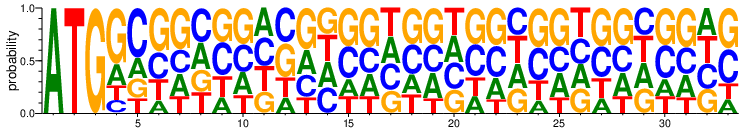

In [35]:
seq.plotlogo()

In [75]:
df = pd.read_csv('../Deseq2 Analysis/shift15/coding/csv_raw/fil5/ER_L24_t1.csv')
df.head(2)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,NM_017847,111.932801,-0.675241,0.277067,-2.437106,0.014805,0.123898
1,NM_001003803,184.246490,-0.145361,0.225600,-0.644331,0.519361,0.787685


In [76]:
en = list(df.loc[df['log2FoldChange']>0.75,'Unnamed: 0'])
dep = list(df.loc[df['log2FoldChange']<-0.75,'Unnamed: 0'])

In [ ]:
for i in range(1,9):
    ids = list(df.loc[df['k_means_8'] == i, 'id'])
    seq = Sequences(Sequences.genes2seq(ids))
    img=seq.plotlogo()
    with open("bit/fil"+str(fil)+"/cluster "+str(i)+".png", "wb") as png:
        png.write(img.data)

In [80]:
seq = Sequences(Sequences.genes2seq(en))
img=seq.plotlogo()
with open("L24_t1_enriched_fil5_prob.png", "wb") as png:
    png.write(img.data)
    
seq = Sequences(Sequences.genes2seq(dep))
img=seq.plotlogo()
with open("L24_t1_depleted_fil5_prob.png", "wb") as png:
    png.write(img.data)

# of valid seqs:  261
# of valid seqs:  36


In [81]:
# Python3 implementation of the above approach 
v = [[] for i in range(100)] 
  
# An utility function to add an edge in an 
# undirected graph. 
def addEdge(x, y): 
    v[x].append(y) 
    v[y].append(x) 
  
# A function to print the path between 
# the given pair of nodes. 
def printPath(stack): 
    for i in range(len(stack) - 1): 
        print(stack[i], end = " -> ") 
    print(stack[-1]) 
  
# An utility function to do 
# DFS of graph recursively 
# from a given vertex x. 
def DFS(vis, x, y, stack): 
    stack.append(x) 
    if (x == y): 
  
        # print the path and return on 
        # reaching the destination node 
        printPath(stack) 
        return
    vis[x] = True
  
    # if backtracking is taking place 
  
    if (len(v[x]) > 0): 
        for j in v[x]: 
              
            # if the node is not visited 
            if (vis[j] == False): 
                DFS(vis, j, y, stack) 
                  
    del stack[-1] 
  
# A utility function to initialise 
# visited for the node and call 
# DFS function for a given vertex x. 
def DFSCall(x, y, n, stack): 
      
    # visited array 
    vis = [0 for i in range(n + 1)] 
  
    #memset(vis, false, sizeof(vis)) 
  
    # DFS function call 
    DFS(vis, x, y, stack) 
  
# Driver Code 
n = 10
stack = [] 
  
# Vertex numbers should be from 1 to 9. 
addEdge(1, 2) 
addEdge(1, 3) 
addEdge(2, 4) 
addEdge(2, 5) 
addEdge(2, 6) 
addEdge(3, 7) 
addEdge(3, 8) 
addEdge(3, 9) 
  
# Function Call 
DFSCall(4, 8, n, stack)

4 -> 2 -> 1 -> 3 -> 8


In [10]:
!pwd

/media/zhaoy/7E0214A802146803/Users/Putatu/Documents/HGLab/RBC/plot cluster


In [11]:
batch = 'ER_L24_t1'
deseq = pd.read_csv('../Deseq2 Analysis/shift15/coding/csv_raw/fil5/'+batch+'.csv')
deseq = deseq.sort_values(by=['log2FoldChange'])
print(len(deseq))
deseq.head(2)

8812


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6582,NM_001142579,27.307252,-1.532826,0.489615,-3.130677,0.001744,0.033410
4853,NM_001352299,56.569596,-0.992991,0.298354,-3.328230,0.000874,0.020985


In [30]:
background = deseq['Unnamed: 0']
deseq_filtered = deseq.loc[deseq['padj']<0.05]
up_num = sum(deseq_filtered['log2FoldChange'] > 0.75)
target = deseq_filtered.tail(up_num)['Unnamed: 0']   # i.e. Interest group, upper right on volcano plot
down_num=sum(deseq_filtered['log2FoldChange']<-0.75)
print(up_num,down_num)


126 17


In [13]:
!mkdir deseq_test
target_seq = Sequences(Sequences.genes2seq(target))
bg_seq = Sequences(Sequences.genes2seq(background))
down_num=sum(deseq_filtered['log2FoldChange']<-1)
dep_seq=Sequences(Sequences.genes2seq(deseq_filtered.head(up_num)['Unnamed: 0']))

ppm_out = pfm2ppm_df(target_seq.pfm)
#ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+batch+"_enriched"+".csv")
ppm_out = pfm2ppm_df(dep_seq.pfm)
#ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+batch+"_depleted"+".csv")
ppm_out = pfm2ppm_df(bg_seq.pfm)
#ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+"bg"+".csv")

mkdir: cannot create directory ‘deseq_test’: File exists
# of valid seqs:  107
# of valid seqs:  8281
# of valid seqs:  125


In [19]:
np.random.seed(1234)
test = TestSeq(target_seq,bg_seq,50000)
test2 = TestSeq(dep_seq,bg_seq,50000,len(target_seq))

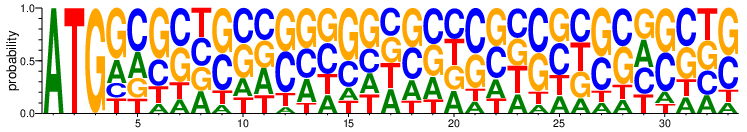

In [20]:
target_seq.plotlogo()

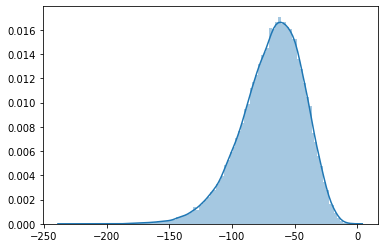

In [21]:
test.logdist()

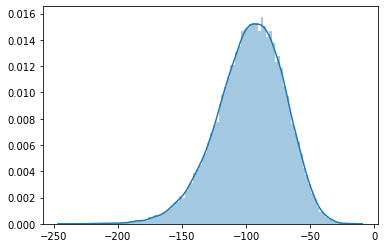

In [22]:
test2.logdist()

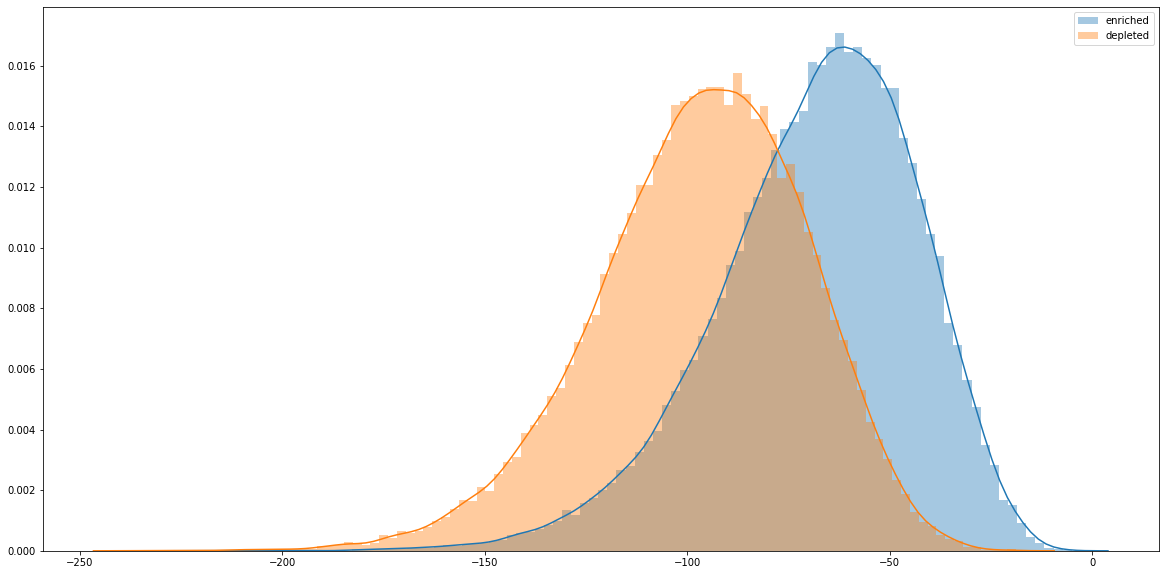

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
test.logdist()
test2.logdist()
ax=plt.gca()
ax.legend(['enriched','depleted'])
plt.savefig('deseq_test/en_vs_dep_pvals.png')

In [31]:
img=bg_seq.plotlogo()
with open("bg_bit.png", "wb") as png:
    png.write(img.data)